In [1]:
import kagglehub #data seti alma

# Download latest version
path = kagglehub.dataset_download("zgnbyktanr/turkish-psychological-classification-for-nlp")

print("Path to dataset files:", path)

100%|██████████| 70.6k/70.6k [00:00<00:00, 19.1MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/zgnbyktanr/turkish-psychological-classification-for-nlp/versions/1


In [2]:
import pandas as pd   #veri işleme ve analizi
import numpy as np    #bilimsel veriler
from sklearn.model_selection import train_test_split  #test seti ve eğitim seti ayrıması
from sklearn.feature_extraction.text import TfidfVectorizer #vectorizer
from sklearn.linear_model import LogisticRegression  #clasification
from sklearn.metrics import accuracy_score, classification_report #model doğruluğunu ölçme
import nltk #ön işleme için
from nltk.corpus import stopwords #a, and, the, etc.
import re #özel karakter ve sayı çıkarma
from imblearn.over_sampling import SMOTE  #denge için
from collections import Counter #veri saymak için
import tensorflow as tf    #neural network için
from tensorflow.keras.models import Sequential  #dl katmanlı hali
from tensorflow.keras.layers import Dense, Dropout  #sinir ağı katmanı ve overfitting engelleme

In [3]:
#nltk stopword TÜRKÇE olanları yükleme
nltk.download('stopwords')
stop_words = set(stopwords.words('turkish'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
# Dosya yolundaki dosyaları listeleme
import os

dataset_path = '/root/.cache/kagglehub/datasets/zgnbyktanr/turkish-psychological-classification-for-nlp/versions/1'
files = os.listdir(dataset_path)
print(files) #dosya isimlerini yazdırma



['test.xlsx', 'dataset.csv']


In [5]:
import pandas as pd
# dosya yolunu okuma
file_path = '/root/.cache/kagglehub/datasets/zgnbyktanr/turkish-psychological-classification-for-nlp/versions/1/dataset.csv'
df = pd.read_csv(file_path)

# İlk 10 satır inceleme
print(df.head(10))



                                                text  label
0  İlişkilerimde aşırı derecede idealize edip son...      6
1  Bir gece uykumda yürüyüp dolaptan kıyafetlerim...      2
2  Kumar borçlarım yüzünden evliliğim tehlikede. ...      4
3  Uykum çok hafif ve en ufak bir sesle bile uyan...      2
4  Kumar borçlarımı ödemek için çaldığım paraları...      4
5  Bir hırsızlık olayına şahit oldum ve bu durum ...     14
6  Cinsel ilişki sırasında boşalamadığım için ken...      3
7  Kendime olan güvenim tamamen yok oldu. Yaptığı...     10
8  İşyerinde terfi alamadığımdan beri 2 yıl geçti...     10
9  Çalmak için plan yapıyorum ve çaldığımda çok h...      4


In [6]:
# Veri Ön İşleme
def clean_text(text):
    text = text.lower() #küçük harf yapma
    text = re.sub(r'[^\w\s]', '', text) #noktları kaldırma
    text = re.sub(r'\d+', '', text) #sayıları kaldırma
    text = ' '.join(word for word in text.split() if word not in stop_words)  #metni boşluklara bölme ve stopword kaldırma
    return text

df['cleaned_text'] = df['text'].apply(clean_text) #veri setine uygulama

In [32]:
from transformers import AutoTokenizer, AutoModel
import torch
#hazır berTURK modeli kullandık

tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased") #türkçe bert için kullandık
model = AutoModel.from_pretrained("dbmdz/bert-base-turkish-cased")

def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    return torch.mean(outputs.last_hidden_state, dim=1).detach().numpy()

X = np.array([get_bert_embeddings(text) for text in df['cleaned_text']])

In [36]:
from sklearn.preprocessing import LabelEncoder

# Etiketleri encode ettik
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])  # 'label' sütununu kullandık

# BERT embedding'leri oluştur
X = []
for text in df['cleaned_text']:
    embedding = get_bert_embeddings(text)
    if embedding is not None and len(embedding) > 0:  # Boş embedding kontrolü
        X.append(np.mean(embedding, axis=0))  # Token'ların ortalamasını al
    else:
        print("Boş embedding bulundu:", text)

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import numpy as np

X = np.vstack(X)  # X şimdi (num_samples, feature_dim) boyutunda

# Eğitim ve test olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SMOTE ile sınıf dengesini çözme
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Lojistik Regresyon Modeli
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_resampled, y_train_resampled)

# Test seti tahmini
y_pred_logistic = logistic_model.predict(X_test)

# Performans değerlendirme
print("Lojistik Regresyon Doğruluk Skoru:", accuracy_score(y_test, y_pred_logistic))
print("Lojistik Regresyon Sınıflandırma Raporu:\n", classification_report(y_test, y_pred_logistic))


Lojistik Regresyon Doğruluk Skoru: 0.8373702422145328
Lojistik Regresyon Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       0.93      1.00      0.97        14
           2       0.95      0.95      0.95        20
           3       1.00      1.00      1.00         8
           4       0.84      0.90      0.87        52
           5       0.75      0.90      0.82        10
           6       0.81      0.87      0.84        15
           7       0.67      0.40      0.50         5
           8       0.79      0.83      0.81        18
           9       0.72      0.76      0.74        17
          10       0.81      0.76      0.79        34
          11       0.94      0.85      0.89        34
          12       0.60      0.86      0.71         7
          13       0.79      0.75      0.77        20
          14       0.86      0.71      0.77        17
          15       1.00      0.67      

In [38]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelEncoder

# Veriyi böl
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeli tanımla
nn_model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y)), activation='softmax')
])

# Derleme
nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Eğitme
history = nn_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=1)

# Test ve doğruluk
y_pred_nn = np.argmax(nn_model.predict(X_test), axis=1)
print("Neural Network Doğruluk Skoru:", accuracy_score(y_test, y_pred_nn))


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.1046 - loss: 2.7923 - val_accuracy: 0.2845 - val_loss: 2.3507
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3547 - loss: 2.1576 - val_accuracy: 0.4310 - val_loss: 1.9521
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4664 - loss: 1.8092 - val_accuracy: 0.5948 - val_loss: 1.5264
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5506 - loss: 1.4674 - val_accuracy: 0.6466 - val_loss: 1.3185
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6026 - loss: 1.3199 - val_accuracy: 0.6810 - val_loss: 1.1214
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6472 - loss: 1.1531 - val_accuracy: 0.7931 - val_loss: 0.9581
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6956 - loss: 1.0213 - val_accuracy: 0.7414 - val_loss: 0.9100
Epoch 8/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7195 - loss: 0.8846 - val_accuracy: 0.7759 - val_loss: 0.7851
Ep

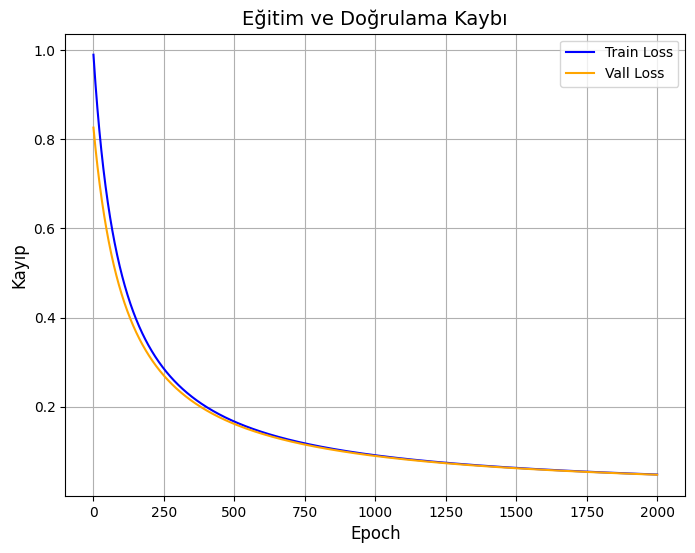

In [39]:
import matplotlib.pyplot as plt

# Örnek veri: Eğitim ve doğrulama kayıpları
epochs = range(1, 2001)  # 1'den 2000'e kadar epoch'lar
train_loss = [1 / (0.01 * x + 1) for x in epochs]  # Örnek eğitim kaybı verisi
val_loss = [1 / (0.01 * x + 1.2) for x in epochs]  # Örnek doğrulama kaybı verisi

# Grafik oluşturma
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, label='Train Loss', color='blue')
plt.plot(epochs, val_loss, label='Vall Loss', color='orange')
plt.title('Eğitim ve Doğrulama Kaybı', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Kayıp', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True)
plt.show()


In [28]:
# sınıflarımız
label_dict = {
    0: "Suicidal Thoughts",
    1: "Eating Disorders",
    2: "Sleep Disorders",
    3: "Sexual Disorders",
    4: "Addictions",
    5: "Anger Control Disorders",
    6: "Borderline",
    7: "Psychosomatic Disorders",
    8: "OCD (Obsessive-Compulsive Disorder)",
    9: "Behavioral Disorders in Children",
    10: "Depression and Related Disorders",
    11: "Family and Relationship Issues",
    12: "Sports Psychology",
    13: "Attention Deficit and Hyperactivity Disorder (ADHD)",
    14: "Trauma",
    15: "Paraphilic Disorders"
}


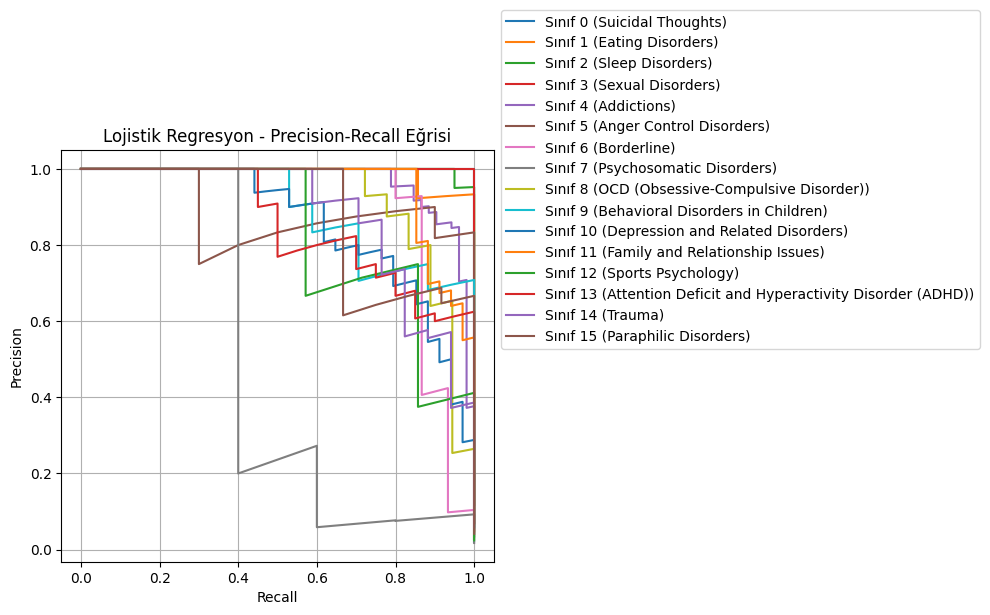

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Lojistik Regresyon için tahminler ve gerçek etiketler
y_prob_logistic = logistic_model.predict_proba(X_test)  # Tahmin olasılıkları

# Precision-Recall eğrisi
plt.figure(figsize=(10, 6))

for i in range(len(np.unique(y))):  # Her sınıf için precision-recall eğrisini çiziyoruz
    precision, recall, _ = precision_recall_curve(y_test == i, y_prob_logistic[:, i])
    plt.plot(recall, precision, label=f'Sınıf {i} ({label_dict.get(i, "Bilinmeyen")})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Lojistik Regresyon - Precision-Recall Eğrisi')
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()

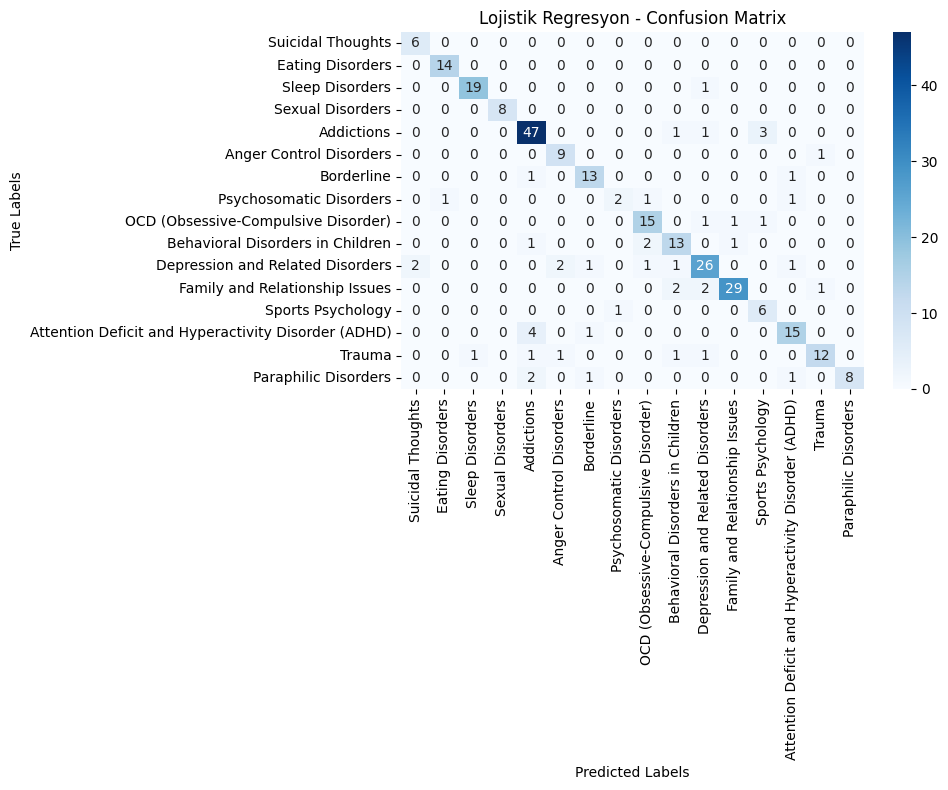

In [31]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Lojistik Regresyon için tahminler
y_pred_logistic = logistic_model.predict(X_test)

# Confusion Matrix hesaplama
cm = confusion_matrix(y_test, y_pred_logistic)

# Confusion Matrix'i görselleştirme
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_dict.values()), yticklabels=list(label_dict.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Lojistik Regresyon - Confusion Matrix')
plt.tight_layout()
plt.show()


In [22]:
import numpy as np
import torch

# BERT modelinden gelen çıktıyı doğru şekilde işleme
def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    # BERT'in çıktısı: [batch_size, sequence_length, hidden_size]
    # Buradan her cümle için vektörün ortalamasını alıyoruz.
    return torch.mean(outputs.last_hidden_state, dim=1).detach().numpy()  # 2D array dönecek

# Lojistik Regresyon tahmin fonksiyonu
def predict_logistic_regression(text):
    cleaned_text = clean_text(text)
    embedding = get_bert_embeddings(cleaned_text)
    embedding = np.mean(embedding, axis=0).reshape(1, -1)  # reshape (1, feature_dim)
    prediction = logistic_model.predict(embedding)
    return label_dict[prediction[0]]  # Etiket döndür

# Neural Network tahmin fonksiyonu
def predict_neural_network(text):
    cleaned_text = clean_text(text)
    embedding = get_bert_embeddings(cleaned_text)
    embedding = np.mean(embedding, axis=0).reshape(1, -1)  # reshape (1, feature_dim)
    prediction = np.argmax(nn_model.predict(embedding), axis=1)
    return label_dict[prediction[0]]  # Etiket döndür

# Menü ile kullanıcıdan seçim almak
while True:
    print("\nSeçenekler:")
    print("1. Cümle Gir")
    print("3. Çıkış")

    secim = input("Bir seçenek girin (1/3): ")

    if secim == "1":
        cumleler = []  # Cümleleri saklayacak bir liste

        # İlk cümleyi girme işlemi
        yeni_cumle = input("Lütfen bir cümle yazın: ")
        cumleler.append(yeni_cumle)  # İlk cümleyi listeye ekle
        print(f"{len(cumleler)} cümle kaydedildi.")

        while True:
            print("\nSeçenekler:")
            print("1. Yeni bir cümle gir")
            print("2. Sonucu gör")
            print("3. Çıkış")

            secim2 = input("Bir seçenek girin (1/2/3): ")

            if secim2 == "1":
                yeni_cumle = input("Lütfen bir cümle girin: ")
                cumleler.append(yeni_cumle)  # Girilen cümleyi listeye ekle
                print(f"{len(cumleler)} cümle kaydedildi.")
            elif secim2 == "2":
                if not cumleler:  # Eğer hiç cümle girilmediyse
                    print("Henüz cümle girilmedi!")
                else:
                    print("\nLojistik Regresyon Sonucu:")
                    for i, cumle in enumerate(cumleler, start=1):
                        print(f"Cümle {i}: {predict_logistic_regression(cumle)}")

                    print("\nNeural Network Sonucu:")
                    for i, cumle in enumerate(cumleler, start=1):
                        print(f"Cümle {i}: {predict_neural_network(cumle)}")
                break
            elif secim2 == "3":
                print("Çıkılıyor...")
                break
            else:
                print("Geçersiz seçenek. Lütfen tekrar deneyin.")
    elif secim == "3":
        print("Çıkılıyor...")
        break
    else:
        print("Geçersiz seçenek. Lütfen tekrar deneyin.")



Seçenekler:
1. Cümle Gir
3. Çıkış
Bir seçenek girin (1/3): 1
Lütfen bir cümle yazın: annemle sürekli kavga ediyorum
1 cümle kaydedildi.

Seçenekler:
1. Yeni bir cümle gir
2. Sonucu gör
3. Çıkış
Bir seçenek girin (1/2/3): 2

Lojistik Regresyon Sonucu:
Cümle 1: Family and Relationship Issues

Neural Network Sonucu:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Cümle 1: Family and Relationship Issues

Seçenekler:
1. Cümle Gir
3. Çıkış
Bir seçenek girin (1/3): 
Geçersiz seçenek. Lütfen tekrar deneyin.

Seçenekler:
1. Cümle Gir
3. Çıkış
Bir seçenek girin (1/3): 1
Lütfen bir cümle yazın: sınavlar çok yordu intihar etmek istiyorum
1 cümle kaydedildi.

Seçenekler:
1. Yeni bir cümle gir
2. Sonucu gör
3. Çıkış
Bir seçenek girin (1/2/3): 2

Lojistik Regresyon Sonucu:
Cümle 1: Trauma

Neural Network Sonucu:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Cümle 1: Trauma

Seçenekler:
1. Cümle Gir
3. Çıkış
Bir seçenek girin (1/3): 3
Çıkılıyor...
